In [1]:
from velocity_field import vel
import numpy as np
from matplotlib import pyplot as plt
from numerical_integrators.single_step import rk2
from numerical_integrators.adaptive_step import rkdp54
%matplotlib inline
# Use LaTeX engine to render text in figure captions, labels etc.
plt.rc('text', usetex = True)

# Default width of figures
figwidth = 10
# Default dpi of figures
resolution = 300

In [12]:
# Generate grid points, inspired by FVM

# Define domain of interest
x_min, x_max = 0, 2
y_min, y_max = 0, 1

# No. of grid points along each axis, scaled s.t. we obtain a uniform grid
Ny = 200
Nx = int(Ny * (x_max - x_min) / (y_max - y_min))

# Total no. of grid points:
N = Nx * Ny

# Grid spacing, main grid:
dx_m = (x_max - x_min) / Nx
dy_m = (y_max - y_min) / Ny

# "Basis" vectors along either direction
x_0 = (np.arange(Nx) + 1/2) * dx_m
y_0 = (np.arange(Ny) + 1/2) * dy_m

# Grid elements of main and auxiliary grids
#    First  batch of Nx*Ny elements: Main grid points 
#    Second  ----------''----------: Right auxiliary grid points
#    Third   ----------''----------: Top    --------''----------
#    Fourth  ----------''----------: Left   --------''----------
#    Fifth   ----------''----------: Bottom --------''----------
x = np.zeros(5*N)
y = np.copy(x)

# Grid spacing, auxiliary grid:
# Should be quite a bit smaller than the main grid
dx_a = 1e-5#dx_m / 1e1
dy_a = 1e-5#dy_m / 1e1

# Auxiliary_grid:
#    First batch of Nx*Ny elements: Right auxiliary grid points
#    Second ----------''----------: Top    --------''----------
#    Third  ----------''----------: Left   --------''----------
#    Fourth ----------''----------: Bottom --------''----------
x_a = np.zeros(N * 4)
y_a = np.zeros(N * 4)

# We generate the (initial) main and auxiliary grids:
for j in range(Ny):
    # Main grid points
    x[      j*Nx :       (j + 1)*Nx] = x_0
    y[      j*Nx :       (j + 1)*Nx] = y_0[j]
    
    # Right auxiliary grid points
    x[  N + j*Nx :   N + (j + 1)*Nx] = x_0 + dx_a
    y[  N + j*Nx :   N + (j + 1)*Nx] = y_0[j]
    
    # Top auxiliary grid points
    x[2*N + j*Nx : 2*N + (j + 1)*Nx] = x_0
    y[2*N + j*Nx : 2*N + (j + 1)*Nx] = y_0[j] + dy_a
    
    # Left auxiliary grid points
    x[3*N + j*Nx : 3*N + (j + 1)*Nx] = x_0 - dx_a
    y[3*N + j*Nx : 3*N + (j + 1)*Nx] = y_0[j]
    
    # Bottom auxiliary grid points
    x[4*N + j*Nx : 4*N + (j + 1)*Nx] = x_0
    y[4*N + j*Nx : 4*N + (j + 1)*Nx] = y_0[j] - dy_a 
    
# We generate arrays containing the (initial) main and auxiliary grids:
pos_init     = np.array([x, y])

(0, 1)

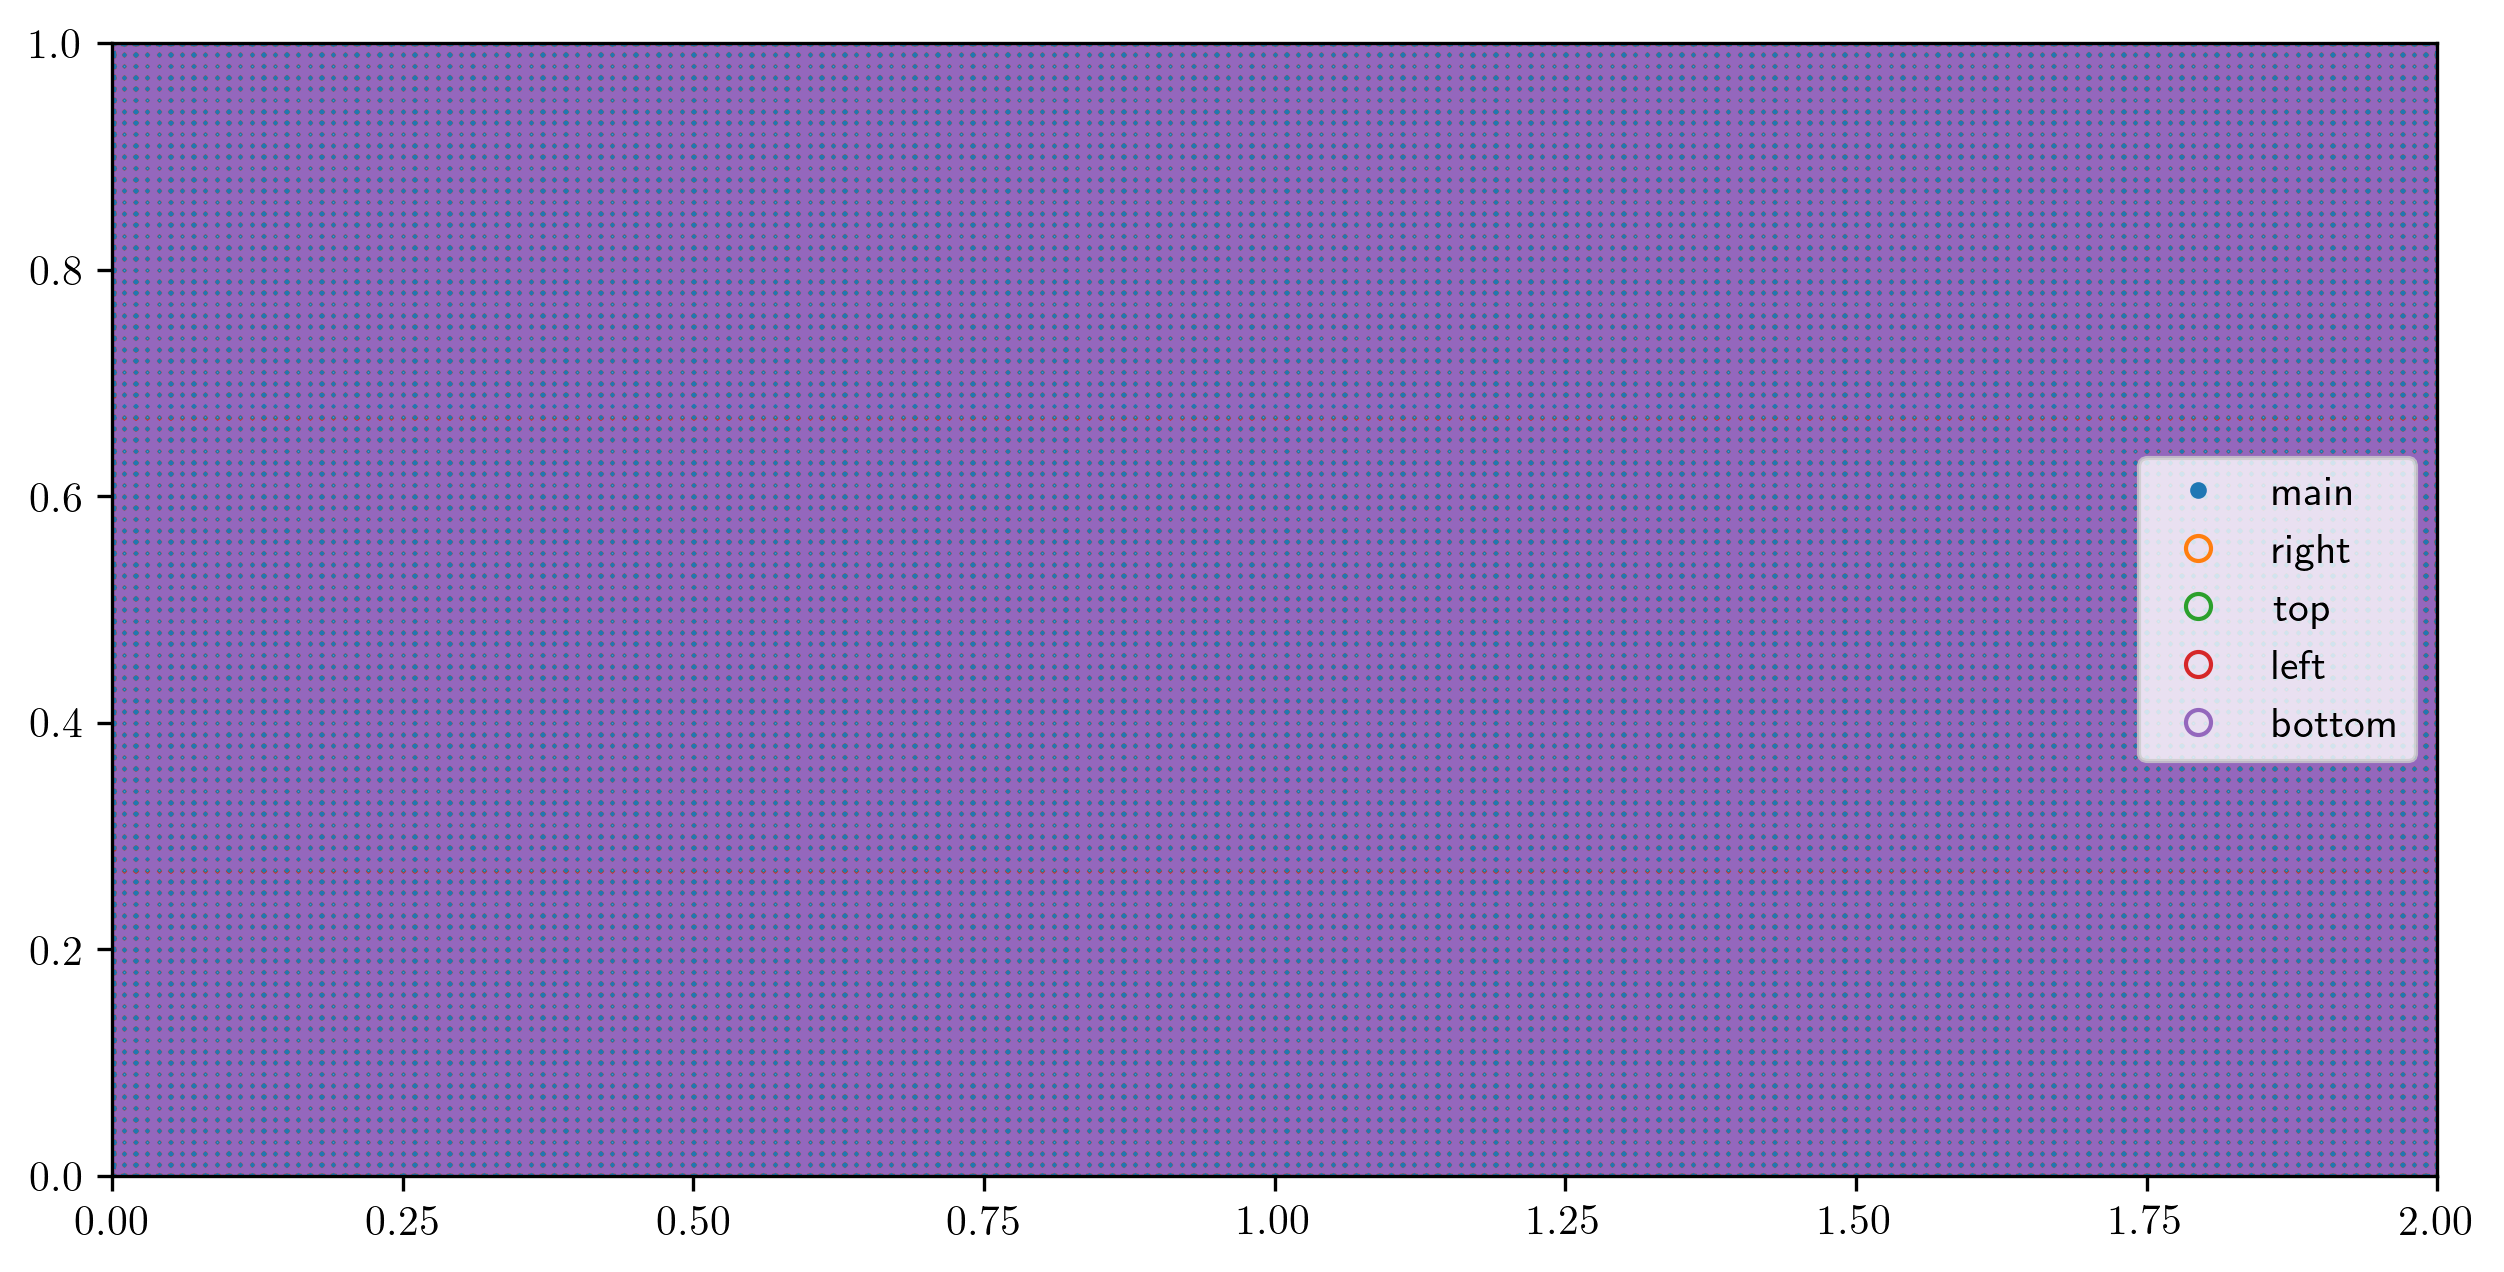

In [3]:
plt.figure(figsize=(figwidth, np.ceil(figwidth*Ny/Nx).astype(int)), dpi = resolution)
plt.plot(pos_init[0, 0:N], pos_init[1, 0:N], '.', label = 'main')
plt.plot(pos_init[0, N:2*N], pos_init[1, N:2*N], 'o', fillstyle = 'none', label = 'right')
plt.plot(pos_init[0, 2*N:3*N], pos_init[1, 2*N:3*N], 'o', fillstyle = 'none', label = 'top')
plt.plot(pos_init[0, 3*N:4*N], pos_init[1, 3*N:4*N], 'o', fillstyle = 'none', label = 'left')
plt.plot(pos_init[0, 4*N:5*N], pos_init[1, 4*N:5*N], 'o', fillstyle = 'none', label = 'bottom')
plt.legend(loc = 'best')
plt.xlim([0, 2])
plt.ylim([0, 1])

In [13]:
# Define time interval of interest:
t_min = 0
t_max = 20

# Define timestep:
h_init = 0.01

# Choose integrator:
integrator = rk2

# Define velocity field parameters:
amplitude = 0.1
epsilon = 0.1
omega = 2*np.pi/10

In [14]:
# Preparations for stepping forwards in time:
pos     = np.copy(pos_init)

def timestep(t, pos, h, integrator, deriv, **kwargs):
    t, pos, h = integrator(t, pos, h, deriv, **kwargs)
    return t, pos, h

h = h_init#np.ones(N) * h_init
t = t_min#np.ones(N) * t_min
# Step forwards in time:
while np.any(np.less(t, t_max)):
    h = np.minimum(h, t_max - t)
    t, pos, h = timestep(t, pos, h, integrator, deriv = vel, A = amplitude, eps = epsilon, w = omega)
    
def compute_auxiliary_stress_tensor(pos):
    # Not really needed
    main_pos = pos[:, 0:N]
    
    # Auxiliary grid is essential
    aux_right_pos = pos[:, N:2*N]
    aux_above_pos = pos[:, 2*N:3*N]
    aux_left_pos  = pos[:, 3*N:4*N]
    aux_beneath_pos = pos[:, 4*N:5*N]
    
    # Jacobian: [dx/dx dx/dy; dy/dx dy/dy]
    aux_jacobian = np.array([[(aux_right_pos[0, :] - aux_left_pos[0, :]) / (2*dx_a), \
                                       (aux_above_pos[0, :] - aux_beneath_pos[0, :]) / (2*dy_a)], \
                            np.array([(aux_right_pos[1, :] - aux_left_pos[1, :]) / (2*dx_a), \
                                       (aux_above_pos[1, :] - aux_beneath_pos[1, :]) / (2*dy_a)])])
    
    #print(aux_right_pos[0, :].shape)
    aux_stress_tensor = np.zeros([2, 2, N])
    # For loop to ensure we find the right tensors
    for j in range(N):
        aux_stress_tensor[:, :, j] = np.dot(aux_jacobian[:, :, j].T, aux_jacobian[:, :, j])

    return aux_stress_tensor

def compute_main_stress_tensor(pos):
    main_pos = pos[:, 0:N]
    
    # Reshape in order to find correct positions more easily
    x = main_pos[0].reshape(Ny, Nx)
    y = main_pos[1].reshape(Ny, Nx)#main_pos.reshape(2, Ny, Nx)

    
    # Jacobian: [dx/dx dx/dy; dy/dx dy/dy]
    
    dxdx = np.zeros((Ny, Nx))
    dxdy = np.copy(dxdx)
    dydx = np.copy(dxdx)
    dydy = np.copy(dxdx)
    
    # We use 2nd order forward/backward difference approx. at the 
    # domain edges, in order to obtain consistent derivatives 
    # throughout
    dxdx[:, 0]    = (-x[:, 2] + 4*x[:, 1] - 3*x[:, 0]) / (2*dx_m)
    dxdx[:, 1:-2] = (x[:, 2:-1] - x[:, 1:-2])/(2*dx_m)
    dxdx[:, -1]   = (3*x[:, -1] -4*x[:, -2] + x[:, -3])/(2*dx_m)
    
    dxdy[0, :]    = (-x[2, :] + 4*x[1, :] - 3*x[0, :])/(2*dy_m)
    dxdy[1:-2, :] = (x[2:-1, :] - x[1:-2, :])/(2*dy_m)
    dxdy[-1, :]   = (3*x[-1, 0] - 4*x[-2, :] + x[-3, :])/(2*dy_m)
    
    dydx[:, 0]    = (-y[:, 2] + 4*y[:, 1] - 3*y[:, 0]) / (2*dx_m)
    dydx[:, 1:-2] = (y[:, 2:-1] - y[:, 1:-2])/(2*dx_m)
    dydx[:, -1]   = (3*y[:, -1] -4*y[:, -2] + y[:, -3])/(2*dx_m)
    
    dydy[0, :]    = (-y[2, :] + 4*y[1, :] - 3*y[0, :])/(2*dy_m)
    dydy[1:-2, :] = (y[2:-1, :] - y[1:-2, :])/(2*dy_m)
    dydy[-1, :]   = (3*y[-1, 0] - 4*y[-2, :] + y[-3, :])/(2*dy_m)
    
    
    dxdx = dxdx.reshape(Nx*Ny)#dxdx.reshape(Nx*Ny)
    dxdy = dxdy.reshape(Nx*Ny)
    dydx = dydx.reshape(Nx*Ny)
    dydy = dydy.reshape(Nx*Ny)
    
    
    #dxdx = np.array([(-x[:, 2] + 4*x[:, 1] - 3*x[:, 0])/(2*dx_m), \
    #                 (x[:, 2:-1].ravel() - x[:, 1:-2].ravel())/(2*dx_m), \
    #                 (3*x[:, -1] - 4*x[:, -2] + x[:, -3])/(2*dx_m)])
    #dxdy = np.array([(-x[2, :] + 4*x[1, :] - 3*x[0, :])/(2*dy_m), \
    #                 (x[2:-1, :].ravel() - x[1:-2, :].ravel())/(2*dy_m), \
    #                 (3*x[-1, :] - 4*x[-2, :] + x[-3, :])/(2*dy_m)])
    
    #dydx = np.array([(-y[:, 2] + 4*y[:, 1] - 3*y[:, 0])/(2*dx_m), \
    #                 (y[:, 2:-1].ravel() - y[:, 1:-2].ravel())/(2*dx_m), \
    #                 (3*y[:, -1] - 4*y[:, -2] + y[:, -3])/(2*dx_m)])
    #dydy = np.array([(-y[2, :] + 4*y[1, :] - 3*y[0, :])/(2*dy_m), \
    #                 (y[2:-1, :].ravel() - y[1:-2, :].ravel())/(2*dy_m), \
    #                 (3*y[-1, :] - 4*y[-2, :] + y[-3, :])/(2*dy_m)])

    main_jacobian = np.array([[dxdx, dxdy], \
                              [dydx, dydy]])
    
    #print(main_jacobian.shape)
    
    main_stress_tensor = np.zeros([2, 2, N])
    
    # For loop to ensure we find the right tensors
    for j in range(N):
        main_stress_tensor[:, :, j] = np.dot(main_jacobian[:, :, j].T, main_jacobian[:, :, j])

    return main_stress_tensor
    
    
    
auxtens = compute_auxiliary_stress_tensor(pos)
maintens = compute_main_stress_tensor(pos)

In [15]:
aux_evals = np.zeros((2, N))
aux_evects = np.zeros((2, 2, N))

for j in range(N):
    #aux_evals[:, j], aux_evects[:, :, j] = np.linalg.eig(auxtens[:, :, j])
    foo, bar = np.linalg.eigh(auxtens[:, :, j])
    
    idx = foo.argsort()[::-1]
    
    aux_evals[:, j],  aux_evects[:, :, j] = foo[idx], bar[:, idx]

main_evals = np.zeros((2, N))
main_evects = np.zeros((2, 2, N))

for j in range(N):
    #main_evals[:, j], main_evects[:, :, j] = np.linalg.eig(maintens[:, :, j])
    foo, bar = np.linalg.eigh(maintens[:, :, j])
    
    idx = foo.argsort()[::-1]
    
    main_evals[:, j], main_evects[:, :, j] = foo[idx], bar[:, idx]

In [16]:
mask_a = np.zeros((N), dtype = bool)

for j in range(N):
    mask_a[j] = np.logical_and(np.less(main_evals[1, j], main_evals[0, j]), np.greater(main_evals[0, j], 1))

In [17]:
mask_b = np.zeros((N), dtype = bool)

evals_largest = np.zeros((N))
evects_largest = np.zeros((2, N))

for j in range(N):
    evals_largest[j] = main_evals[0, j]
    evects_largest[:, j] = aux_evects[:, 0, j]
    
evals_largest = evals_largest.reshape(Ny, Nx)
evects_largest = evects_largest.reshape(2, Ny, Nx)

delxdelx_evals_largest = np.zeros((Ny, Nx))
delydely_evals_largest = np.zeros((Ny, Nx))

# Second order forward/backward difference for the domain edges
delxdelx_evals_largest[:, 0] = (2*evals_largest[:,0] - 5*evals_largest[:,1] + 4 * evals_largest[:,2] - evals_largest[:,3])/(dx_m**2)
delxdelx_evals_largest[:, 1:-2] = (evals_largest[:, 2:-1] - 2*evals_largest[:, 1:-2] + evals_largest[:, 0:-3])/(dx_m**2)
delxdelx_evals_largest[:, -1] = (2*evals_largest[:, -1] - 5*evals_largest[:, -2] + 4*evals_largest[:, -3] - evals_largest[:, -4])/(dx_m**2)

delydely_evals_largest[0, :] = (2*evals_largest[0,:] - 5*evals_largest[1,:] + 4*evals_largest[2,:] - evals_largest[3,:])/(dy_m**2)
delydely_evals_largest[1:-2, :] = (evals_largest[2:-1, :] - 2*evals_largest[1:-2, :] + evals_largest[0:-3, :])/(dy_m**2)
delydely_evals_largest[-1, :] = (2*evals_largest[-1, :] - 5*evals_largest[-2, :] + 4*evals_largest[-3, :] - evals_largest[-4, :])/(dy_m**2)

laplacian_evals_largest = delxdelx_evals_largest + delydely_evals_largest

laplacian_evals_largest = laplacian_evals_largest.reshape(N)

evects_largest = evects_largest.reshape(2, N)



In [18]:
innerprod = np.zeros(N)
for j in range(N):
    innerprod[j] = np.dot(evects_largest[:,j], laplacian_evals_largest[j]*evects_largest[:,j])

In [19]:
mask_b = np.greater(innerprod, 0)

(0, 1)

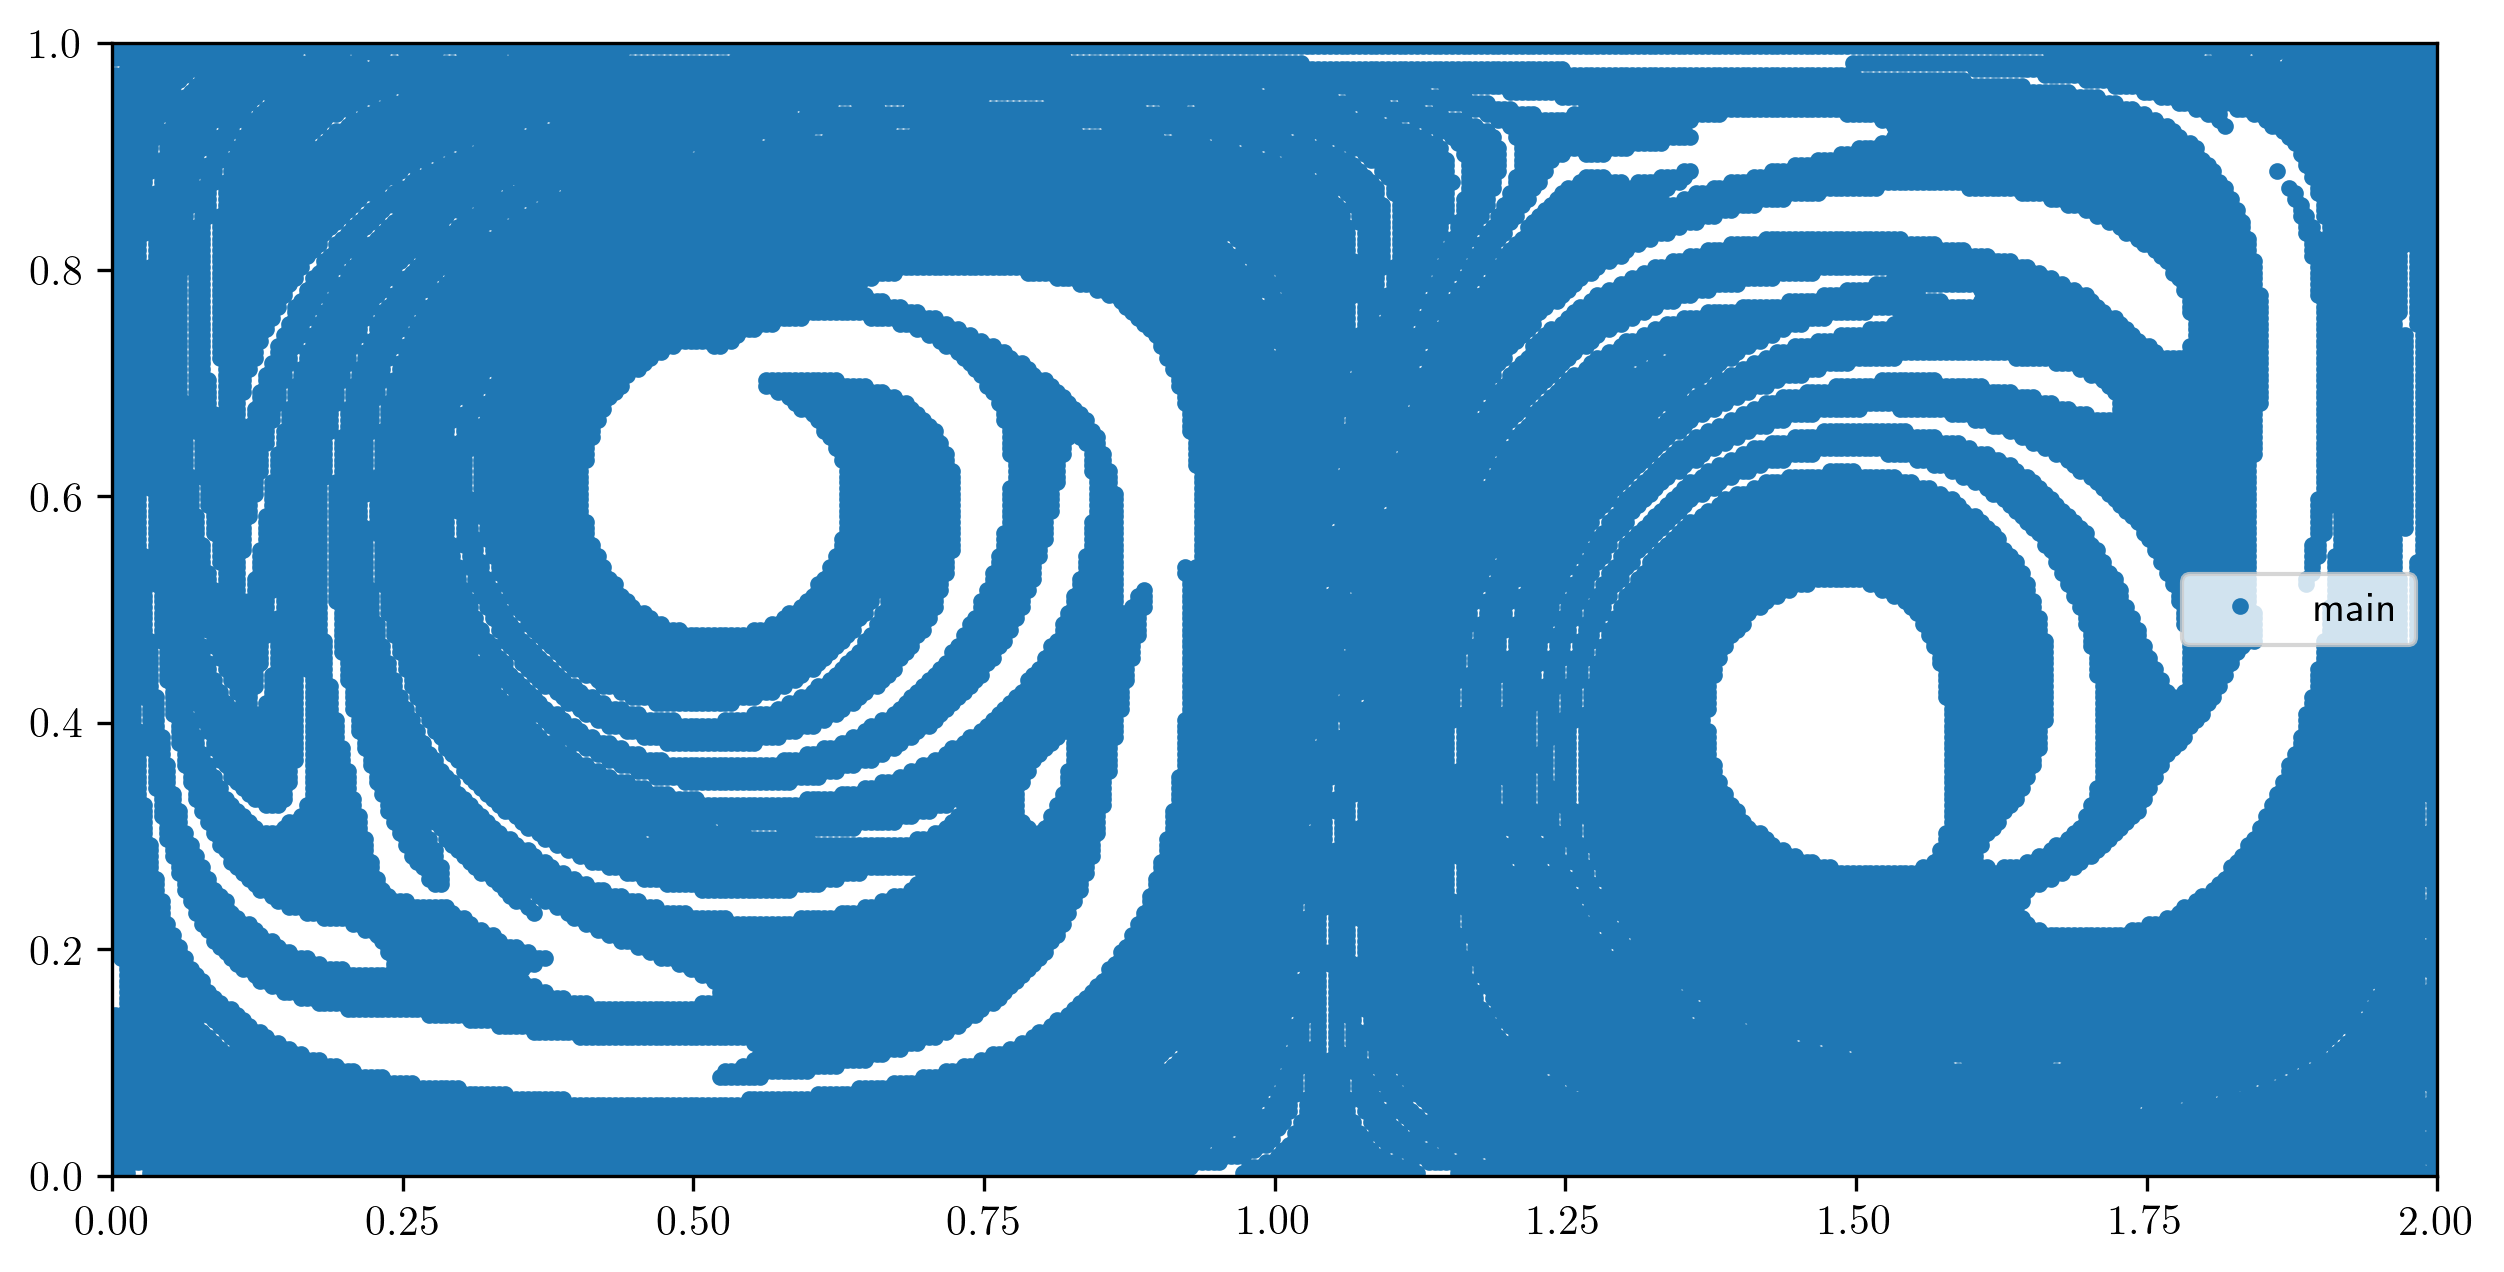

In [24]:
plt.figure(figsize=(figwidth, np.ceil(figwidth*Ny/Nx).astype(int)), dpi = resolution)
plt.plot(pos_init[0, 0:N] * np.logical_and(mask_a, mask_b), pos_init[1, 0:N] * np.logical_and(mask_a, mask_b), '.', label = 'main')
#plt.plot(pos[0, N:2*N], pos[1, N:2*N], 'o', fillstyle = 'none', label = 'right')
#plt.plot(pos[0, 2*N:3*N], pos[1, 2*N:3*N], 'o', fillstyle = 'none', label = 'top')
#plt.plot(pos[0, 3*N:4*N], pos[1, 3*N:4*N], 'o', fillstyle = 'none', label = 'left')
#plt.plot(pos[0, 4*N:5*N], pos[1, 4*N:5*N], 'o', fillstyle = 'none', label = 'bottom')
plt.legend(loc = 'best')
plt.xlim([0, 2])
plt.ylim([0, 1])

In [31]:
dx_m

1.0

In [32]:
print(np.linalg.eig.__doc__)


    Compute the eigenvalues and right eigenvectors of a square array.

    Parameters
    ----------
    a : (..., M, M) array
        Matrices for which the eigenvalues and right eigenvectors will
        be computed

    Returns
    -------
    w : (..., M) array
        The eigenvalues, each repeated according to its multiplicity.
        The eigenvalues are not necessarily ordered. The resulting
        array will be of complex type, unless the imaginary part is
        zero in which case it will be cast to a real type. When `a`
        is real the resulting eigenvalues will be real (0 imaginary
        part) or occur in conjugate pairs

    v : (..., M, M) array
        The normalized (unit "length") eigenvectors, such that the
        column ``v[:,i]`` is the eigenvector corresponding to the
        eigenvalue ``w[i]``.

    Raises
    ------
    LinAlgError
        If the eigenvalue computation does not converge.

    See Also
    --------
    eigvals : eigenvalues of a non-sym

In [12]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [13]:
A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [9]:
eigvals, eigvecs = np.linalg.eig(A)

In [10]:
eigvals

array([  1.61168440e+01,  -1.11684397e+00,  -9.75918483e-16])

In [14]:
eigvecs

array([[-0.23197069, -0.78583024,  0.40824829],
       [-0.52532209, -0.08675134, -0.81649658],
       [-0.8186735 ,  0.61232756,  0.40824829]])

In [24]:
l = eigvals[0]
ksi = eigvecs[0]

In [26]:
l

16.116843969807043

In [31]:
eigvals, eigvecs = np.linalg.eig(A.T)

In [32]:
eigvals

array([  1.61168440e+01,  -1.11684397e+00,  -1.57673427e-16])

In [33]:
eigvecs

array([[-0.46454727, -0.88290596,  0.40824829],
       [-0.57079553, -0.23952042, -0.81649658],
       [-0.67704379,  0.40386512,  0.40824829]])

In [34]:
A.T

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

In [53]:
A = np.array(([2, 3], [3, 2]))

In [54]:
eigvals, eigvecs = np.linalg.eig(A)

In [55]:
eigvals

array([ 5., -1.])

In [56]:
eigvecs

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [58]:
np.dot(A, eigvecs[1])

array([ 3.53553391,  3.53553391])

In [52]:
eigvecs[1]

array([ 0.70710678,  0.70710678])

In [59]:
eigvecs[1]

array([ 0.70710678,  0.70710678])

In [60]:
eigvecs[0]

array([ 0.70710678, -0.70710678])

In [61]:
A

array([[2, 3],
       [3, 2]])

In [62]:
eigvals[0]

5.0

In [65]:
np.dot(A, eigvecs[0]) - eigvals[1] * eigvecs[0]

array([  2.22044605e-16,  -9.99200722e-16])

In [66]:
eigvecs.T

array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]])

In [69]:
np.dot(A, eigvecs.T[0]) - eigvals[0] * eigvecs.T[0]

array([  4.44089210e-16,   0.00000000e+00])

In [3]:
A = np.array([[2, 3], [3, 2]])

In [4]:
l, ksi = np.linalg.eig(A)

In [5]:
l

array([ 5., -1.])

In [9]:
idx = l.argsort()

In [10]:
l[idx]

array([-1.,  5.])

In [11]:
ksi

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [12]:
ksi[idx]

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

In [13]:
ksi[:, idx]

array([[-0.70710678,  0.70710678],
       [ 0.70710678,  0.70710678]])

In [14]:
ksi = ksi[:, idx]

In [15]:
l = l[idx]

In [16]:
l

array([-1.,  5.])

In [17]:
ksi

array([[-0.70710678,  0.70710678],
       [ 0.70710678,  0.70710678]])

In [18]:
np.dot(A, ksi[0, :])

array([ 0.70710678, -0.70710678])

In [30]:
B = np.zeros([[[2, 2],*4]])

TypeError: 'int' object is not iterable

In [20]:
B

array([[ 0.,  0.],
       [ 0.,  0.]])

In [39]:
A = np.array([[1, 2], (3, 4)])

In [65]:
main_pos= pos_init[:, 0:N]

In [66]:
main_pos

array([[ 0.25,  0.75,  1.25,  1.75,  0.25,  0.75,  1.25,  1.75],
       [ 0.25,  0.25,  0.25,  0.25,  0.75,  0.75,  0.75,  0.75]])

In [68]:
main_pos.reshape(2, Ny, Nx)

array([[[ 0.25,  0.75,  1.25,  1.75],
        [ 0.25,  0.75,  1.25,  1.75]],

       [[ 0.25,  0.25,  0.25,  0.25],
        [ 0.75,  0.75,  0.75,  0.75]]])

In [69]:
main_pos.reshape(2, Ny*Nx)

array([[ 0.25,  0.75,  1.25,  1.75,  0.25,  0.75,  1.25,  1.75],
       [ 0.25,  0.25,  0.25,  0.25,  0.75,  0.75,  0.75,  0.75]])

In [70]:
A = np.array([[[], []], [], []])

In [71]:
A

array([list([[], []]), list([]), list([])], dtype=object)

In [37]:
main_pos

array([[ 0.88485846,  0.27121291,  1.22188796,  1.22599063,  0.85506704,
         0.27924155,  1.87609183,  1.4191488 ],
       [ 0.46760759,  0.04629259,  0.95413006,  0.24239726,  0.04408364,
         0.77431098,  0.80550832,  0.92781285]])

In [40]:
x = main_pos[0].reshape(Ny, Nx)
y = main_pos[0].reshape(Ny, Nx)

In [39]:
x

array([[ 0.88485846,  0.27121291,  1.22188796,  1.22599063],
       [ 0.85506704,  0.27924155,  1.87609183,  1.4191488 ]])

In [90]:
A = np.array([[42], [list(x)], [13]])

ValueError: setting an array element with a sequence.

In [83]:
x = np.arange(3)

In [84]:
x

array([0, 1, 2])

In [91]:
list(x)

[0, 1, 2]

In [94]:
a = [1, list(x), 2]

In [95]:
a

[1, [0, 1, 2], 2]

In [96]:
a[1]

[0, 1, 2]